In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from pathlib import Path
import fooof
import shutil
from pandas.core.frame import DataFrame
import scipy.io  as sio
import numpy as np
import pandas as pd
from fooof import FOOOFGroup,  FOOOF

def get_project_root() -> Path:
    """Return a base path of current folder, similar to R packege 'here'.
        
    Returns:
        Path: Path object pointing to the parent of the folder where the script is located.
            If your script is `/root/scripts/script.py`, the result will be an absolute path '/root'.
    """
    try:
        return Path(__file__).parent.parent
    except NameError as error:
        # This will give you  root folder of the project if this runned through jupyter notebook
        return Path().joinpath().absolute().parents[0]
    except Exception as exception:
        print(exception)

In [4]:

def process_single_recording_session(path: str) -> DataFrame:
    """[summary]

    Args:
        path (str): [description]

    Returns:
        DataFrame: [description]
    """

    try:    
        data_dict =  mat2dict_scout_psd(path)
        freqs_data  = data_dict["freqs"] 
        powers_data = data_dict["powers"]
        #plot_spectra(freqs_data, powers_data, log_powers=True)
        peaks_df = psd_fooof(freqs_data, powers_data)
        peaks_df = add_columns(peaks_df, data_dict)
        return peaks_df
    except OSError as err:
        print("OS error: {0}".format(err))


def mat2dict_scout_psd(path: str) -> dict:
    """Load content of matfile containg PSD of scouts into Python dict

    Args:
        mat_content (str): Path to file, may be a string or pathlike object

    Returns:
        dict: Dictionary containing all the information  extracted from mat file
    """

    def get_real_names(row_names):
        row_names=  [l.flatten()[0] for l in row_names.flatten()] #flatten
        row_names = [i.split('@')[0] for i in row_names] #delete location
        row_names = [x.strip(' ') for x in row_names]
        row_names = [x.replace(' ', '_') for x in row_names] #remove 
        return row_names

    def split(strng, sep, pos):
        strng = strng.split(sep)
        return sep.join(strng[:pos]), sep.join(strng[pos:])

    #print(sorted(mat_content.keys()))
    #print(mat_content["TF"])
    mat_content = sio.loadmat(path)
    tf = np.ndarray.squeeze(mat_content["TF"])
    row_names = mat_content["RowNames"]
    row_names = get_real_names(row_names)
    freqs = np.ndarray.squeeze(mat_content["Freqs"])
    comment = mat_content["Comment"].tolist()[0].split('|')[1]
    subject_cond = split(comment, "_", 2)[0]
    
    resample = split(split(comment, "_", 5)[1],"_",2)[0]
    condition = comment.split('_Destrieux_')[1]
    data_dict = {'freqs' : freqs, 'powers' : tf, 'row_names' : row_names, 'subject_cond' : subject_cond, 'resample' : resample, 'condition': condition}
    if len(tf)==0:
        print ("TF is empty")
    else:
        return  data_dict  



def fooof2pandas(func):
    """Decorator for fooof function that will transform  foood output into datafram

    Args:
        func ([type]): [description]
    """
    def wrapper(*args, **kwargs):

        fg = func(*args, **kwargs)
        print('Number of model fits: ', len(fg))
        temp_df = pd.DataFrame() # prepare error and slope dataframe
        #temp_df['knee'] = fg.get_params('aperiodic_params', 'knee')
        temp_df['offset'] = fg.get_params('aperiodic_params', 'offset')
        temp_df['exponent'] = fg.get_params('aperiodic_params', 'exponent')

        temp_df['errors']= fg.get_params('error')
        temp_df['r2s']=fg.get_params('r_squared')
        temp_df.insert(0, 'ID', temp_df.index)
        
        peaks = fg.get_params('peak_params') # prepare peaks dataframe
        peaks_df = pd.DataFrame(peaks)
        peaks_df.columns = ['CF', 'PW', 'BW', 'ID']
        peaks_df['ID'] = peaks_df['ID'].astype(int)
        peaks_df = peaks_df.join(temp_df.set_index('ID'), on='ID')
        return peaks_df
    return wrapper


@fooof2pandas
def psd_fooof(freqs, spectra) -> DataFrame:
    """Use FOOOFGroup on data

    Args:
        freqs ([type]): vector with frequencies
        spectra ([type]): Matrix with ROIS x PSD values  #TODO check format

    Returns:
        DataFrame: Fooof values as outputed  in model
    """
    fg = FOOOFGroup(peak_width_limits=[2.5, 8],min_peak_height=0.05, max_n_peaks=6)
    fg.fit(freqs, spectra, freq_range=[3, 48],n_jobs=-1, progress='tqdm')
    return fg


def add_columns(peaks_df: DataFrame, data_dict: DataFrame) -> DataFrame :
    """Add metadata to fooof results

    Args:
        peaks_df (DataFrame): dataframe containing fooof results
        data_dict (DataFrame): dataframe containing metadata related to trial

    Returns:
        DataFrame: [description]
    """
    temp_df = pd.DataFrame()   
    temp_df["ROI"] = data_dict["row_names"]
    temp_df.insert(0, 'ID', temp_df.index)
    temp_df["subject_cond"] = data_dict["subject_cond"]
    temp_df["subjectID"] = data_dict["subject_cond"][:-2]
    temp_df["subject_cond"] = temp_df['subject_cond'].astype('category').str.strip()
    temp_df["condition"] = data_dict["condition"]
    temp_df["S"] = data_dict["condition"]

    temp_df["resample"] = data_dict["resample"]
    x = {'01_resample':'pre', '03_resample':'pre', '02_resample':'post','04_resample':'post'}
    temp_df['P'] = temp_df['resample'].map(x)
    peaks_df = peaks_df.join(temp_df.set_index('ID'), on='ID')
    return peaks_df




def run_pipeline(data_path:str, coding_path: str) -> DataFrame:
    """Load data and output  dataframe

    Returns:
        DataFrame: Values from FOOOF model together with metadata for all subjects
    """

    print(data_path)
    pathlist = Path(data_path).rglob('*.mat')
    pandas_list = []
    for path in pathlist:
        peaks_df=  process_single_recording_session(path)
        pandas_list.append(peaks_df)
    df = pd.concat(pandas_list)
    df2 = load_conditions_coding(coding_path)
    return df.merge(df2, left_on='subject_cond', right_on='subject_cond')


def format_dataframe(final , list_of_columns) -> DataFrame:
    final["subjectID"] = final.subjectID.str.replace(' ', '') #trick with replacing
    final_export = final[list_of_columns]
    final_export = final_export.drop_duplicates()
    final_export = final_export.sort_values(by=['subjectID','ROI', "T", "P"])

    return final_export

# Get fooofed data in the loop

In [5]:
root= get_project_root()
data_path = root / 'data' / 'matlab' / 'tDCS_MEG'
coding_path = root / 'data' / 'metadata' / 'keys.mat'
df = run_pipeline(data_path,coding_path)

/Users/daniel/PhD/Projects/projects-notes/Projects/102 Publish the analysis of the Pellegrino MEG data/MEG-ASSR Pipeline/data/matlab/tDCS_MEG


KeyError: 'TF'

# Format dataframe in a specific way 

In [6]:
list_of_columns = ['subjectID','S', 'T', 'P', 'ROI','offset','exponent','errors','r2s']
final = format_dataframe(df,  list_of_columns)
csv_path = root / 'output' / 'share' / 'ROI_offset_exponent_dataframe.csv'
final.to_csv(csv_path, index = False, header=True)

# Examine the conditions

In [7]:
def check_outliers(df, column_name, thresh):
    """Calculate indices of outliers, as defined by a standard deviation threshold."""
    data =  df[column_name]
    return df[data < thresh ]

<AxesSubplot:>

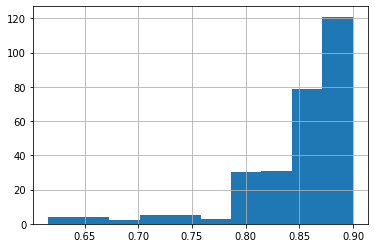

In [8]:
std_outliers = check_outliers(df, "r2s", 0.9)
std_outliers["r2s"].hist()

# Example - Average on one specific ROI

In [12]:
fdf = final[((final["subjectID"] == "Subject01") | (final["subjectID"] == "Subject02")) & (final["ROI"] == "G_Ins_lg_and_S_cent_ins_L")]
fdf = fdf[fdf["S"] == "PRESTIM"]
fdf

,subjectID,S,T,P,ROI,offset,exponent,errors,r2s
23251,Subject01,PRESTIM,real,post,G_Ins_lg_and_S_cent_ins_L,-22.371743,0.958904,0.017749,0.995928
22750,Subject01,PRESTIM,real,pre,G_Ins_lg_and_S_cent_ins_L,-22.263523,1.086222,0.024018,0.992713
16868,Subject01,PRESTIM,sham,post,G_Ins_lg_and_S_cent_ins_L,-22.200775,1.129508,0.036272,0.988568
17709,Subject01,PRESTIM,sham,pre,G_Ins_lg_and_S_cent_ins_L,-22.117062,1.192250,0.024770,0.994684
32485,Subject02,PRESTIM,real,post,G_Ins_lg_and_S_cent_ins_L,-20.595597,1.555009,0.031866,0.995185
32951,Subject02,PRESTIM,real,pre,G_Ins_lg_and_S_cent_ins_L,-20.745733,1.464939,0.045010,0.988511
2951,Subject02,PRESTIM,sham,post,G_Ins_lg_and_S_cent_ins_L,-21.230887,1.303688,0.026604,0.995178
2477,Subject02,PRESTIM,sham,pre,G_Ins_lg_and_S_cent_ins_L,-21.217970,1.312977,0.035440,0.991363


In [13]:
fdf = fdf.groupby(["T","P", "ROI"]).mean().reset_index()
fdf = fdf[["T","P", "ROI",'offset','exponent']]
fdf

,T,P,ROI,offset,exponent
0,real,post,G_Ins_lg_and_S_cent_ins_L,-21.483670,1.256957
1,real,pre,G_Ins_lg_and_S_cent_ins_L,-21.504628,1.275581
2,sham,post,G_Ins_lg_and_S_cent_ins_L,-21.715831,1.216598
3,sham,pre,G_Ins_lg_and_S_cent_ins_L,-21.667516,1.252614


In [ ]:
print(fdf.to_markdown())

# Average by subjects

In [14]:
list_of_columns = ['subjectID', 'S', 'T', 'P', 'ROI','offset','exponent','errors','r2s']
avg_baseline = format_dataframe(df,  list_of_columns)
avg_baseline = avg_baseline[avg_baseline["S"] == "PRESTIM"]
avg_baseline = avg_baseline.groupby(["T","P", "ROI"]).mean().reset_index()
avg_baseline = avg_baseline[["T","P", "ROI",'offset','exponent']]
avg_baseline

,T,P,ROI,offset,exponent
0,real,post,G_Ins_lg_and_S_cent_ins_L,-21.678196,1.193868
1,real,post,G_Ins_lg_and_S_cent_ins_R,-21.655477,1.161558
2,real,post,G_and_S_cingul-Ant_L,-21.723008,0.966972
3,real,post,G_and_S_cingul-Ant_R,-21.833406,0.978669
4,real,post,G_and_S_cingul-Mid-Ant_L,-21.992732,1.061280
...,...,...,...,...,...
587,sham,pre,S_temporal_inf_R,-21.204743,1.037134
588,sham,pre,S_temporal_sup_L,-21.204904,1.207352
589,sham,pre,S_temporal_sup_R,-20.886362,1.263381
590,sham,pre,S_temporal_transverse_L,-20.956618,1.193699


<AxesSubplot:>

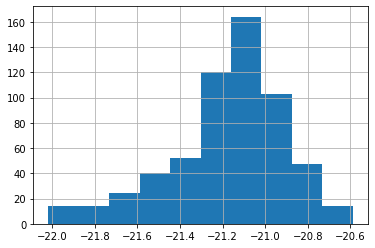

In [15]:
avg_baseline.offset.hist()


<AxesSubplot:>

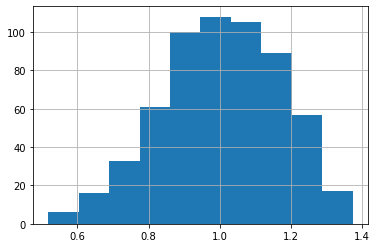

In [16]:
avg_baseline.exponent.hist()

In [17]:
baseline_path = root / 'output' / 'share' / 'averaged_by_subject_ROI_offset_exponent_dataframe.csv'
avg_baseline.to_csv(baseline_path, index = False, header=True)